# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

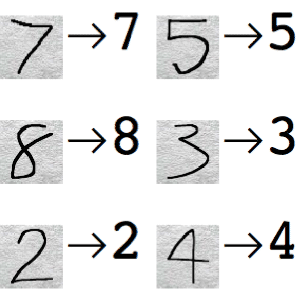

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


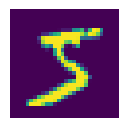

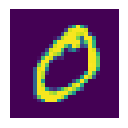

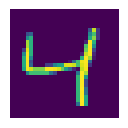

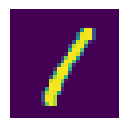

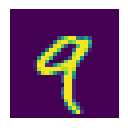

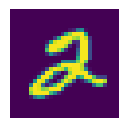

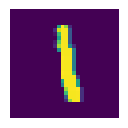

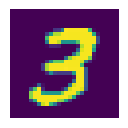

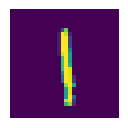

In [88]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i])#, cmap=plt.get_cmap('grey'))
  # show the figure
  #print_matrix(trainX[i])
  plt.axis('off')  # Turn off axis labels
  plt.show()

In [89]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [90]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [91]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [92]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [113]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=50, validation_data=(testX, testY))#, verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [114]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [115]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [111]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

/home/tony/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8775 - loss: 0.3883 - val_accuracy: 0.9706 - val_loss: 0.1000
Epoch 2/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9773 - loss: 0.0774 - val_accuracy: 0.9760 - val_loss: 0.0813
> 97.600
Epoch 1/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8749 - loss: 0.4000 - val_accuracy: 0.9581 - val_loss: 0.1412
Epoch 2/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9702 - loss: 0.1028 - val_accuracy: 0.9716 - val_loss: 0.0981
> 97.158
Epoch 1/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8761 - loss: 0.4001 - val_accuracy: 0.9677 - val_loss: 0.1110
Epoch 2/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9755 - loss: 0.0869 - val_accuracy: 0.9718 - val_loss: 0.0865
> 97.183
Epoch 1/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8696 - loss: 0.4156 - val_accuracy: 0.9682 - val_loss: 0.1068
Epoch 2/2
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9756 - loss: 0.0878

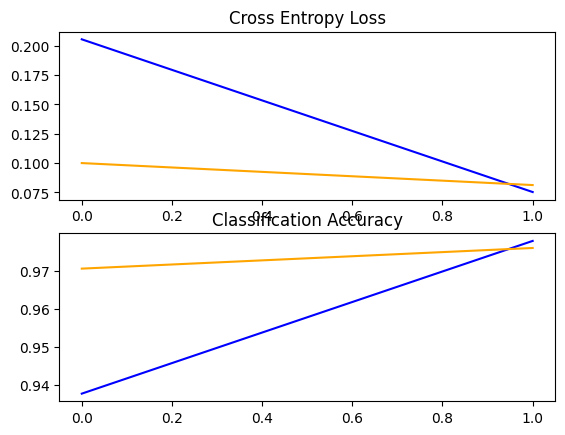

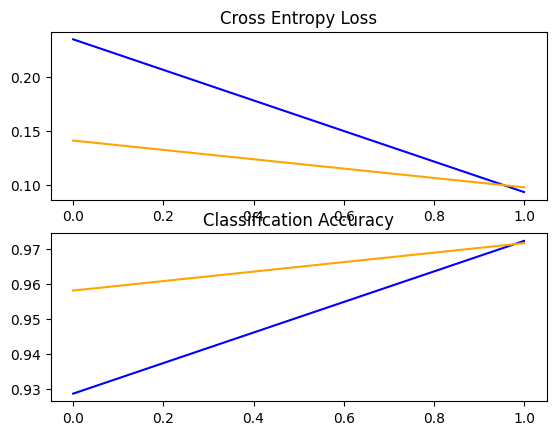

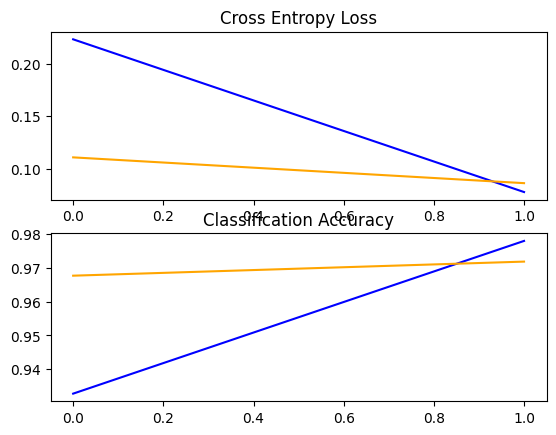

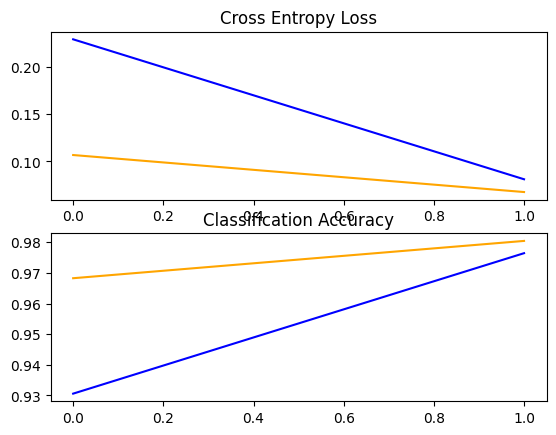

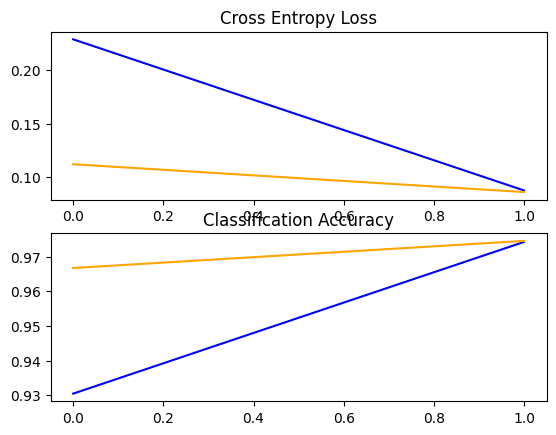

Accuracy: mean=97.488 std=0.323, n=5


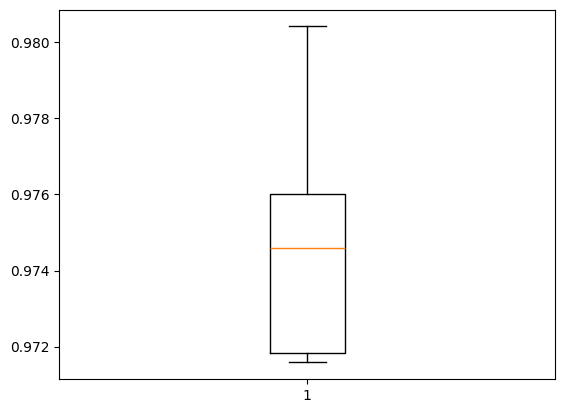

In [112]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [17]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32)#, verbose=0)

  # save model
  model.save('model.keras')

## Evaluate Final Model

In [18]:
# run the test harness for evaluating a model
run_test_harness2()

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9041 - loss: 0.3050
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9831 - loss: 0.0594
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9879 - loss: 0.0381
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9922 - loss: 0.0262
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9947 - loss: 0.0183
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9968 - loss: 0.0120
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9975 - loss: 0.0088
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9983 - loss: 0.0072
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9993 - loss: 0.0038
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9991 - loss: 0.0041


## Make Prediction

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import load_model # type: ignore
from numpy import argmax
from tensorflow.keras.utils import load_img, img_to_array # type: ignore
import os


2024-05-24 04:29:10.837197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 04:29:11.326292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
thumuc = os.getcwd() + "/../data"
files = sorted(os.listdir(thumuc))

In [14]:
def load_image(path):
    # Load the image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"{path}"

    # Otsu's thresholding after Gaussian filtering - https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    #img = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    #_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #img = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    #img = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

    # Resize the image to 28x28
    img = cv2.resize(img, (28, 28))

    # check if image is nagative 
    average_brightness = img.mean()
    if average_brightness > 100:
        img = 255 - img

    # Reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)

    # Prepare pixel data
    img = img.astype('float32') / 255.0

    # Print the 28x28 image array
    #print_matrix(img.reshape(28, 28))

    # Display the image (without the batch dimension)
    plt.imshow(img.reshape(28, 28))#, cmap=plt.get_cmap('grey'))
    plt.axis('off')  # Hide axes for better display
    plt.show()


    return img

model = load_model('model.keras')

2024-05-24 04:33:36.331281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 04:33:36.369718: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


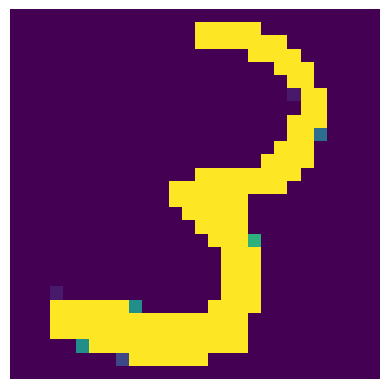

4a0c74856ba9ff78e4f2a5f888d6b4c7  -.jpg,3


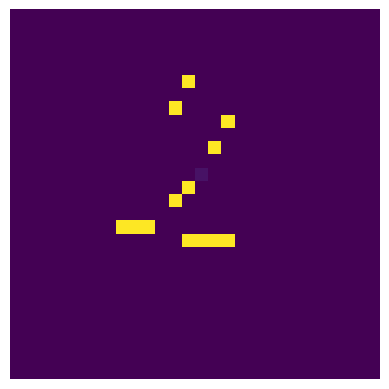

4a21958ce06321b45c2bcf3c5164ee46  -.jpg,2


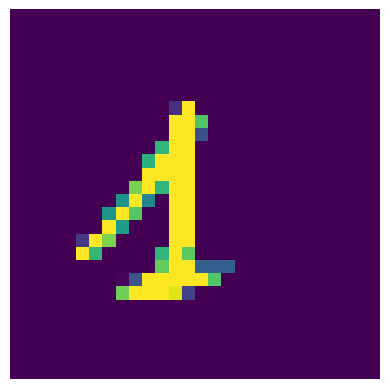

4a42dc490be60cd59cbea2c448665a90  -.png,1


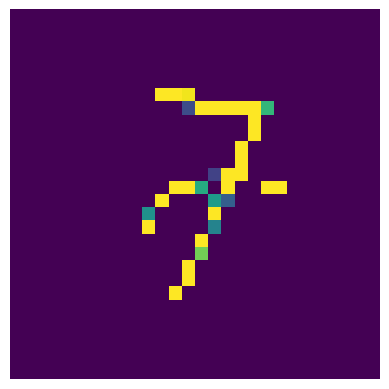

4a42f04a46f568f62f778893bacdfc6a  -.jpg,7


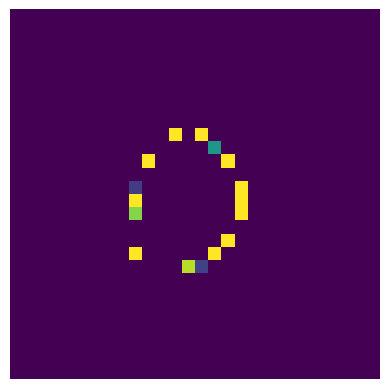

4a68d497429dcd37d9df5b84301b9777  -.jpg,0


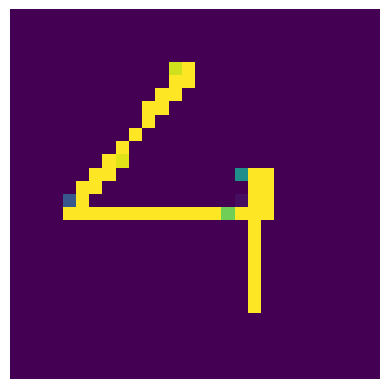

4a6be94bc1fcf68eadd2d9a3a7fab49b  -.jpg,4


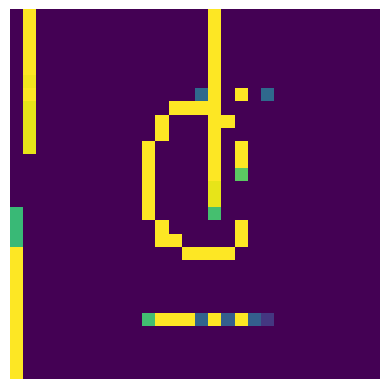

4a727b07ab0610f15d052aecc0332998  -.jpg,6


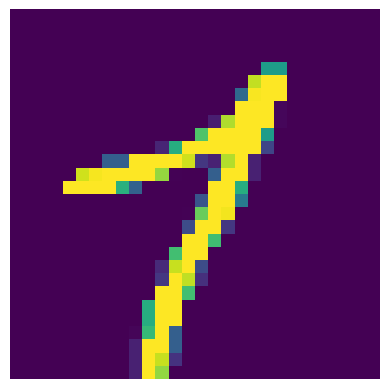

4a74b2f35cbeb4ed9c1f008262cf7a89  -.jpg,7


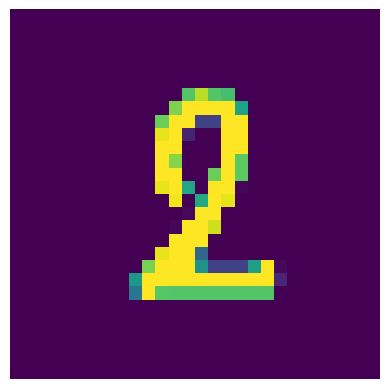

4acf1a7f163b5f4d34be20f4c051041d  -.png,2


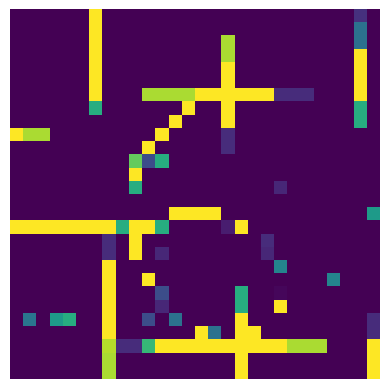

4ade98b67b1a7095cce2a2e79fc26433  -.jpg,5


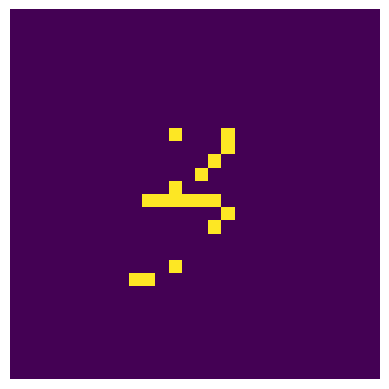

4ae92ca825cc9a58244ee1283ef74578  -.jpg,4


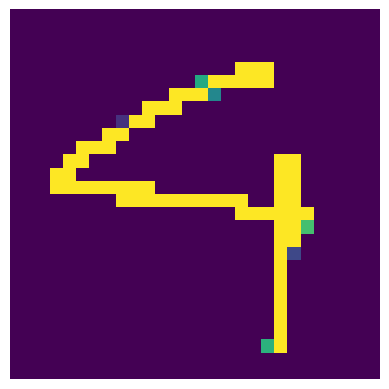

4af74afd6b15bbcd87508e1b5cbb30a9  -.png,9


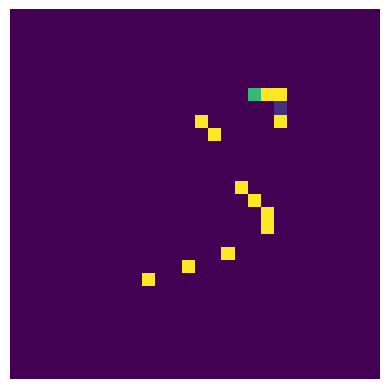

4afdb405e3b469da6c5fb1d0db740890  -.jpg,5


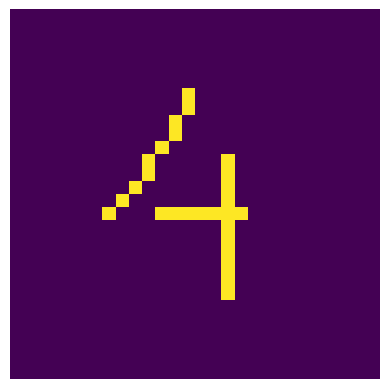

4b0b2c11c2e0b852f909d23c99de8e47  -.jpg,4


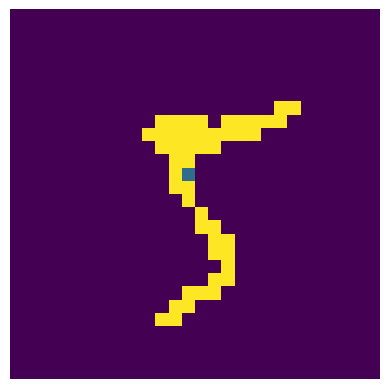

4b60e720d725109bdee9243cee78640c  -.jpg,5


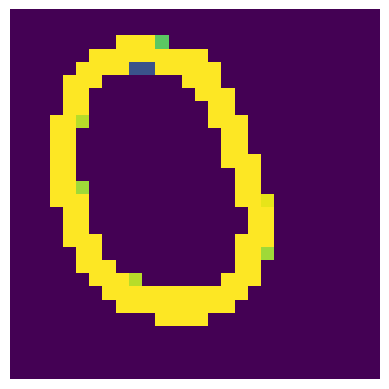

4b8400cc5520a0a0d3fd7227ff9b405d  -.png,0


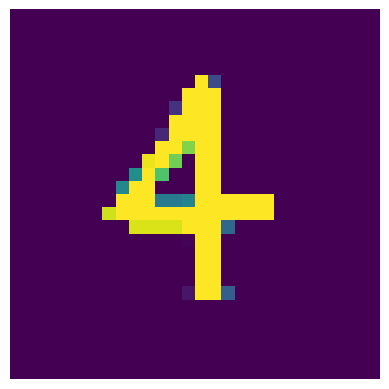

4b8eea5925ba296d1757d7dcb1ab1b53  -.png,4


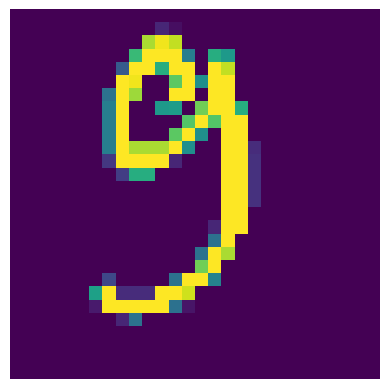

4b93f6b4a734a63c96c03a70fd80ebea  -.png,3


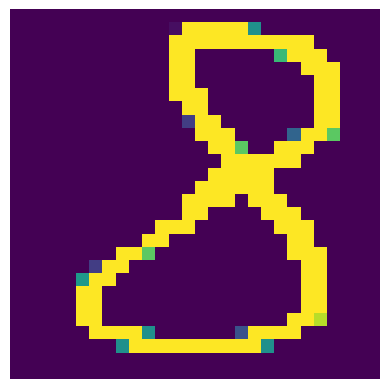

4b9fa79643b962191afeceafd83276bf  -.jpg,8


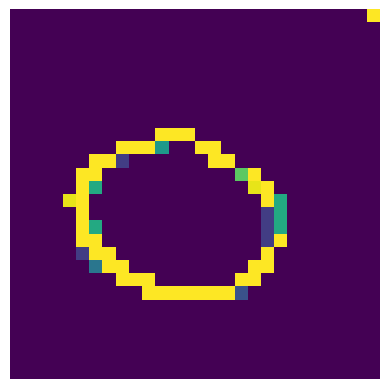

4bbcc10c7b97cd1431905f21e8e27756  -.jpg,0


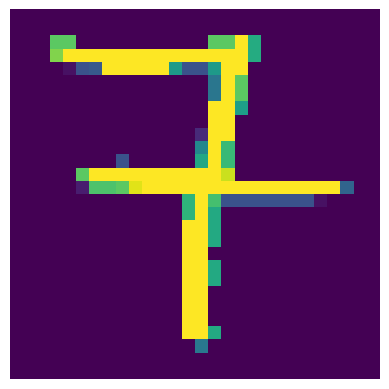

4bdf7aeadda691d586720a7a28272386  -.jpg,7


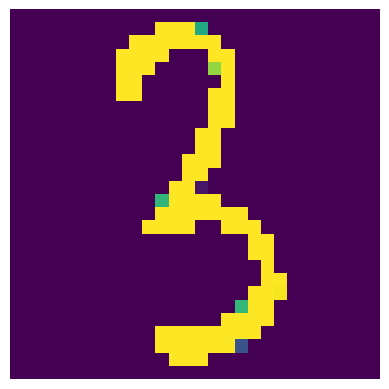

4c0f8388023f9d5f5aa1fca552bc918c  -.png,3


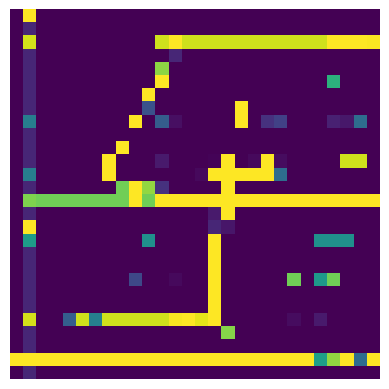

4c173515044bd34d765b37ddd2e97469  -.jpg,5


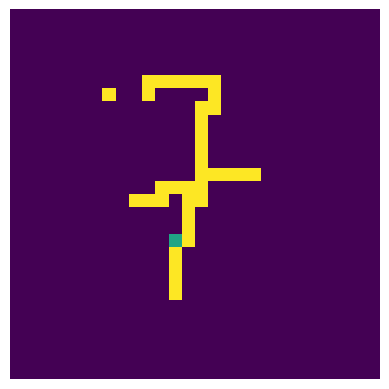

4c32a51d2bb4d68a3af41b26554cea2e  -.png,7


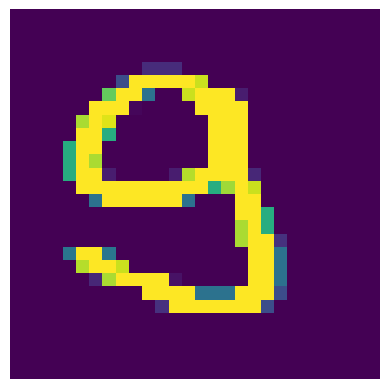

4c383f2fd57d367280ecd1f16fe69bd3  -.png,9


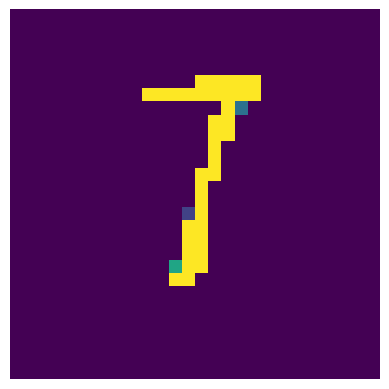

4c471338f9620cf91ed3ab955470904a  -.png,7


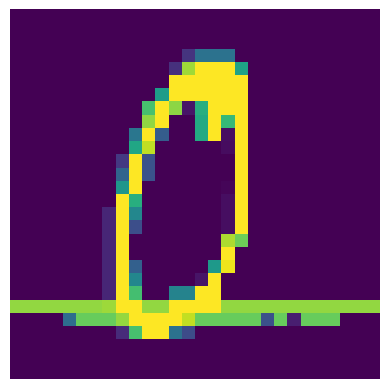

4c74dd5b14b95eba9b254f0356aedd56  -.png,0


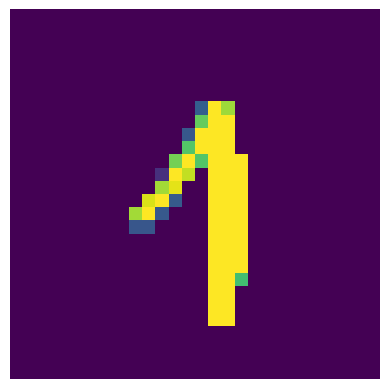

4c7d049dd4dcb5fb095ba1fe2e4a366b  -.png,1


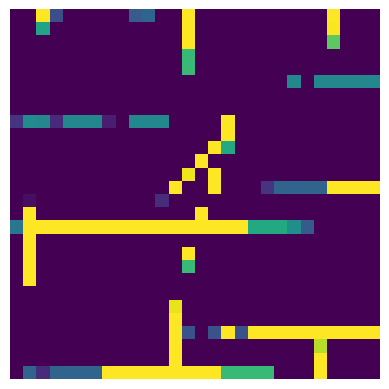

4c81b70d109c4e58d8b9c3fa30cec846  -.jpg,2


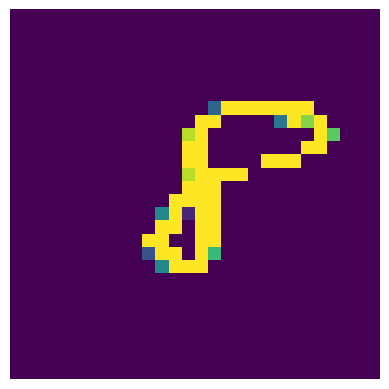

4c929efa3f6b9009b00745944853a040  -.jpg,1


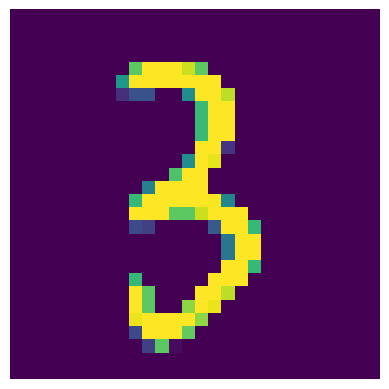

4c966962273240d7dd1a52de5e3d4d5e  -.png,3


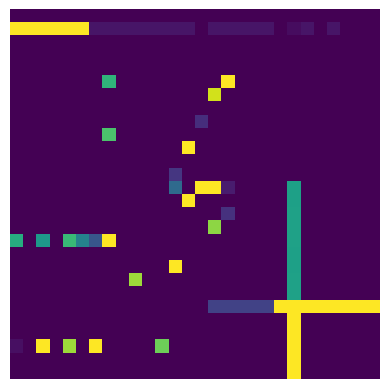

4ca1bafb9d8176b01230be5dbfae3e07  -.jpg,2


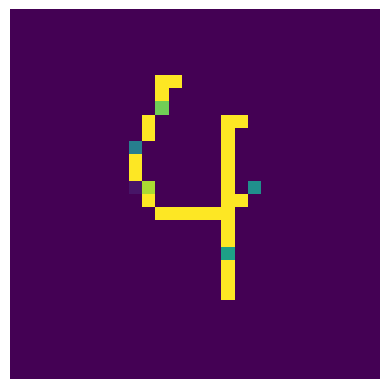

4ca5feeb85918fcc99e9fb1e1a14f46a  -.png,4


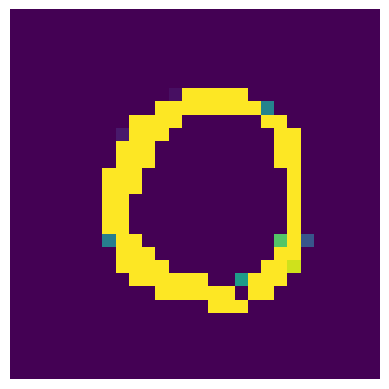

4cdc955c9d23efa56225d800c98510bf  -.jpg,0


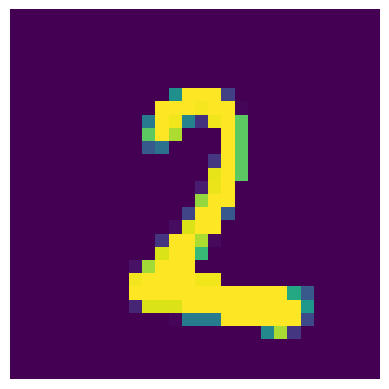

4ce764c71aba668c8ddcd895379eaa7c  -.png,2


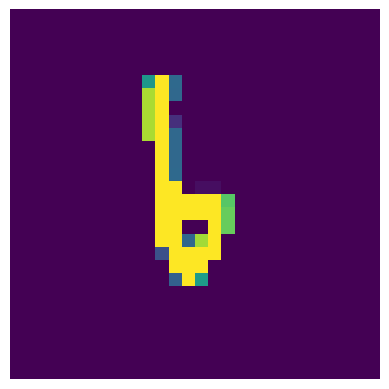

4d2542d9ad84a579894c7b53a1942ab6  -.png,1


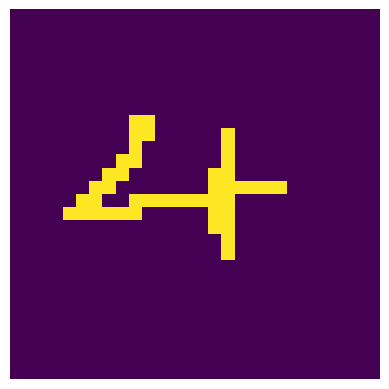

4d4102bc9d7658955ae6bded808fe603  -.jpg,4


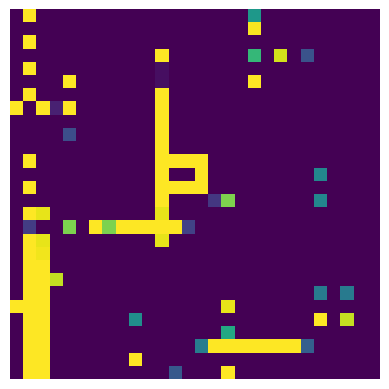

4d6bac6e90cf9ebddc3c4f75eb90dc3d  -.jpg,2


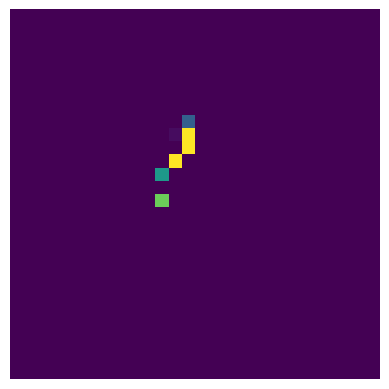

4d81ee9cd00a446bde6933f9d7230074  -.jpg,1
/home/tony/ml/temp/../data/4d8a0d9e667cc03d9a1f4d5ea33497a8  -.md


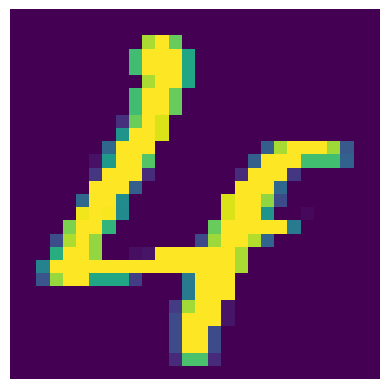

4d8dfaf7f0a022e634fb5b8a02387eda  -.jpg,4


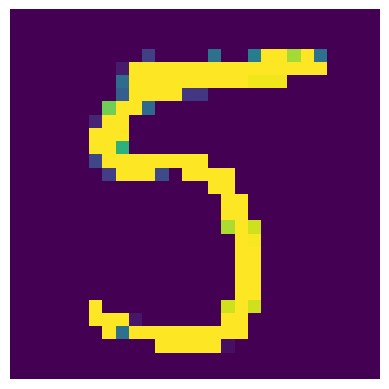

4d905e9f5a70ca1c92f47e1d24e1d5cd  -.png,5


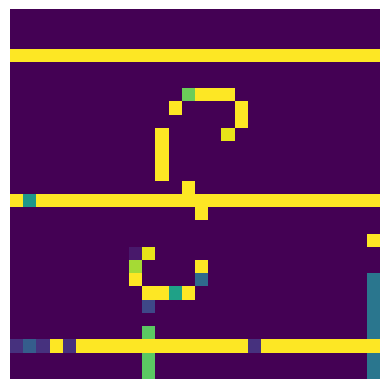

4dc0b06ec710dec41c35c5eb0f60e9c3  -.jpg,3


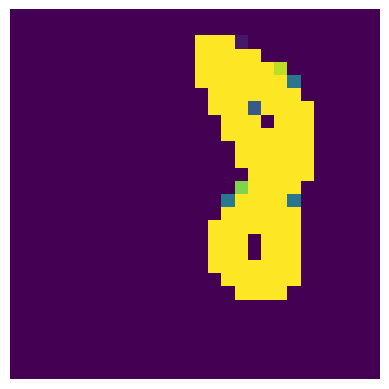

4dc496d674101e9ed26156d051d1421e  -.png,2


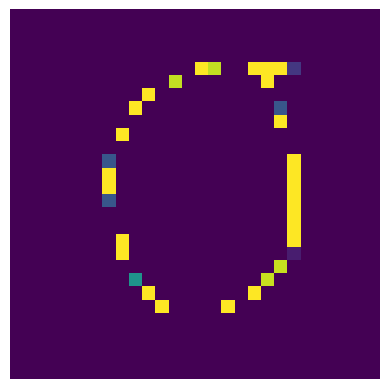

4e0ddacb6dbe3ce054bd06d4b2f23201  -.jpg,0


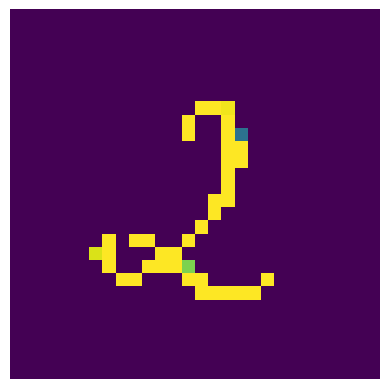

4e16a7747dd3d03c5f2d0edcdc566884  -.png,2


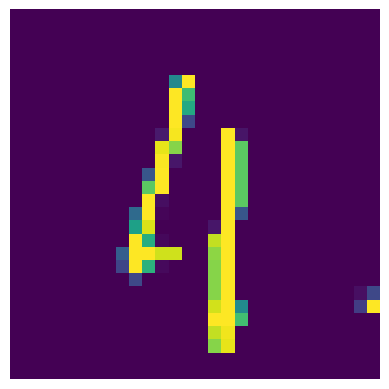

4e35eecbc2436a4a1183e6470c7f7f44  -.png,4


In [15]:
# load an image and predict the class
def run():
  for file in files[870:917:1]:
    try:
      # load the image
      img = load_image(f"{thumuc}/{file}")
      # predict the class
      predict_value = model.predict(img, verbose=0)
     
      digit = argmax(predict_value)
      print(f"{file},{digit}")
      #print(file)

      #debug predict_vale array
      #print(predict_value)

    except Exception as e:
      #print(f"{file},8")
      print(e)
run()

In [10]:
def print_matrix(matrix):
    for row in matrix:
        print(" ".join(map(str, row)))
   
